# Stakeholder

A real estate company is looking to invest in non-luxury, single-family homes in King County, WA. They think this market will grow over time. They want information on several factors that influence the price of such homes.

In this project I define a non-luxury, single-family home as a house less than $3 million dollars, with over 1500 square feet of living space, and 3 or more bedrooms.

In [247]:
import pandas as pd
pd.set_option('display.max_columns', 500)

from matplotlib import pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_rainbow
import scipy.stats as stats
from scipy.stats import kstest
from scipy.stats import shapiro
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
import itertools
import plotly.express as px
import geopy.distance
from IPython.display import clear_output

from sklearn.model_selection import train_test_split

In [89]:
houses = pd.read_csv("data/kc_house_data.csv")

# Functions

I list all the functions I use in this project here. As a result, the rest of the project will be more readable.

In [90]:
def scatter(df, cols):
    fig, ax = plt.subplots(6,5, figsize=(25,20))
    fig.tight_layout(pad=3)

    for i in range(30):

        row = i//5
        col=i%5

        try:
            ax[row][col].scatter(df[cols[i]], df.price)
            ax[row][col].set_title(cols[i], size=15)
        except:
            break

In [91]:
def hist(df, cols):
    fig, ax = plt.subplots(1,5, figsize=(25,5))
    fig.tight_layout(pad=5.0)

    for i in range(5):

        row = i//5
        col=i%5

        ax[i].hist(df[cols[i]], bins=100)
        ax[i].set_title(cols[i], size=25)

In [92]:
def value_counts(df):
    
    for col in df.columns:
        if df[col].nunique() < 100:
            value_counts = dict(df[col].value_counts())
            for key in value_counts.keys():
                if value_counts[key] <= 10:
                    df = df[~(df[col] == key)]
                
    return df

In [93]:
def variable_strength(df, var_list):
    col_dict = {"variables": var_list, "rsquared_adj": []}

    for col in var_list:
        model = sm.OLS.from_formula(f"price ~ {col}", data=df)
        results = model.fit()
        col_dict["rsquared_adj"].append(results.rsquared_adj)

    return pd.DataFrame(col_dict).sort_values(by="rsquared_adj", ascending=False)

# Outliers

In [94]:
houses = \
houses[
    (houses["price"]<10000000) &
    (houses["price"]>300000) &
    (houses["sqft_living"]>600) &
    (houses["sqft_living"]<7500) &
    (houses["sqft_above"]>250) &
    (houses["sqft_above"]<6500) &
    (houses["sqft_lot"]<=500000) &
    (houses["sqft_patio"]<1500) &
    (houses.long > -125) & 
    (houses.long < -121.6) & 
    (houses.lat > 47.1) & 
    (houses.lat<47.8)
]

In [95]:
houses = value_counts(houses)

# Feature Engineering

In this section we will [].

A house's zipcode allows us to see how nearby houses are priced. This could be useful information in determining the price of a house. The density of a zipcode determines how crowded it is; this could also be a factor in how a house is priced.

The zipcodes are contained in the "address" variable. Each address is formatted like this:

``'houses number + street, city, state + zipcode, country'``

Extracting the zipcode only requires a pandas **map** method and python's built-in string-splitting functionality.

Once the zipcode is extracted, it will be placed in a column of its own. Then, for each house, we will calculate the average house price in its zipcode. Each house's price will be excluded from its own average, to avoid a house helping to predict its own price.

The density will just be the number of houses in the zipcode. We will only include zipcodes with more than 50 houses; this is an arbitrary cutoff point to ensure we are working with sufficient data. There were 73 unique zipcodes in total that had >50 houses.

In [96]:
houses['patio'] = houses['sqft_patio'].map(lambda x: 0 if x == 0 else 1)
houses['basement'] = houses['sqft_basement'].map(lambda x: 0 if x == 0 else 1)
houses['garage'] = houses['sqft_garage'].map(lambda x: 0 if x == 0 else 1)

In [97]:
houses['grade'] = houses['grade'].map(lambda x: x.split(" ")[0]).astype(int)
houses['waterfront'] = houses['waterfront'].map({'NO': 0, 'YES': 1})
houses['greenbelt'] = houses['greenbelt'].map({'NO': 0, 'YES': 1})
houses['nuisance'] = houses['nuisance'].map({'NO': 0, 'YES': 1})
houses['view'] = houses['view'].map({'NONE': 0, 'AVERAGE': 1, 'GOOD': 2, 'EXCELLENT': 3, 'FAIR': 4})
houses['condition'] = houses['condition'].map({'Poor': 0, 'Fair': 1, 'Average': 2, 'Good': 3, 'Very Good': 4})

In [98]:
houses['renovated'] = houses['yr_renovated'].map(lambda x: 0 if x==0 else 1)

In [99]:
houses['zipcode'] = houses.address.map(lambda x: x.split(',')[-2].split(' ')[-1])

zipcode_prices = []
for i in range(len(houses)):
    zipcode = houses.iloc[i].zipcode
    identifier = houses.iloc[i].id
    subset = houses[(houses.zipcode == zipcode) & (houses.id != identifier)]
    zipcode_price = subset.price.mean()
    zipcode_prices.append(zipcode_price)
    clear_output(wait=True)
    print(f"cell number {i} out of {len(houses)-1} done.")
    
houses['zipcode_price'] = zipcode_prices
houses['density'] = houses.zipcode.map(dict(houses.zipcode.value_counts()))

cell number 28104 out of 28104 done.


In [100]:
# Creating a "coordinate" variable in a lat/long tuple format.
houses['coordinate'] = list(zip(houses['lat'], houses['long']))

# This calculates the distance of every house from the center of inhabited territory.
center = ((houses.lat.min() + houses.lat.max())/2), ((houses.long.min() + houses.long.max())/2)
houses['distance_from_center'] = houses['coordinate'].map(lambda x: geopy.distance.geodesic(x, center).km)

highest_price = (47.62637851929106, -122.22555549295355)
houses['distance_from_bellevue'] = houses['coordinate'].map(lambda x: geopy.distance.geodesic(x, highest_price).km)

In [101]:
lat_square = (47.213232398310396 - 47.1992389962046)
long_square = (-121.38307527465054 - -121.3939406543853)

# For every house, we calculate how many houses are in a square-shaped area around them.
# Also, we calculate the average price of houses in that area.
# From this data we get average price of houses in the vicinity as well as the density of that area.
# The house whose price we are trying to predict is eliminated from the mean vicinity price.
# Only houses sold before the target house are included in the mean price.

lengths = []
vicinity_means = []

for i in range(len(houses)):
    lat, long = houses.iloc[i].lat, houses.iloc[i].long
    area = houses[(houses.lat < lat+lat_square) & 
                  (houses.lat > lat-lat_square) & 
                  (houses.long < long+long_square) & 
                  (houses.long > long-long_square) & 
                  (houses.long != long) & 
                  (houses.lat != lat)]

    lengths.append(len(area))
    vicinity_means.append(area.price.mean())
    
    clear_output(wait=True)
    print(f"cell number {i} out of {len(houses)-1} done.")

cell number 28104 out of 28104 done.


In [102]:
houses['vicinity_density'] = lengths
houses['vicinity_price'] = vicinity_means

In [138]:
houses.dropna(inplace=True)

In [139]:
df = houses.copy()

to_drop = ['id', 'date', 'yr_renovated', 
         'lat', 'long', 'zipcode', 
         'coordinate', 'address']

# Non-linear relationships with price

- bedrooms
- sqft_lot
- floors
- view
- density
- distance_from_center

Other variables we will not use:

- sqft_basement (too many zeros)
- sqft_garage (too many zeros)
- sqft_patio (too many zeros)
- yr_renovated (too many zeroes)
- latitude
- longitude

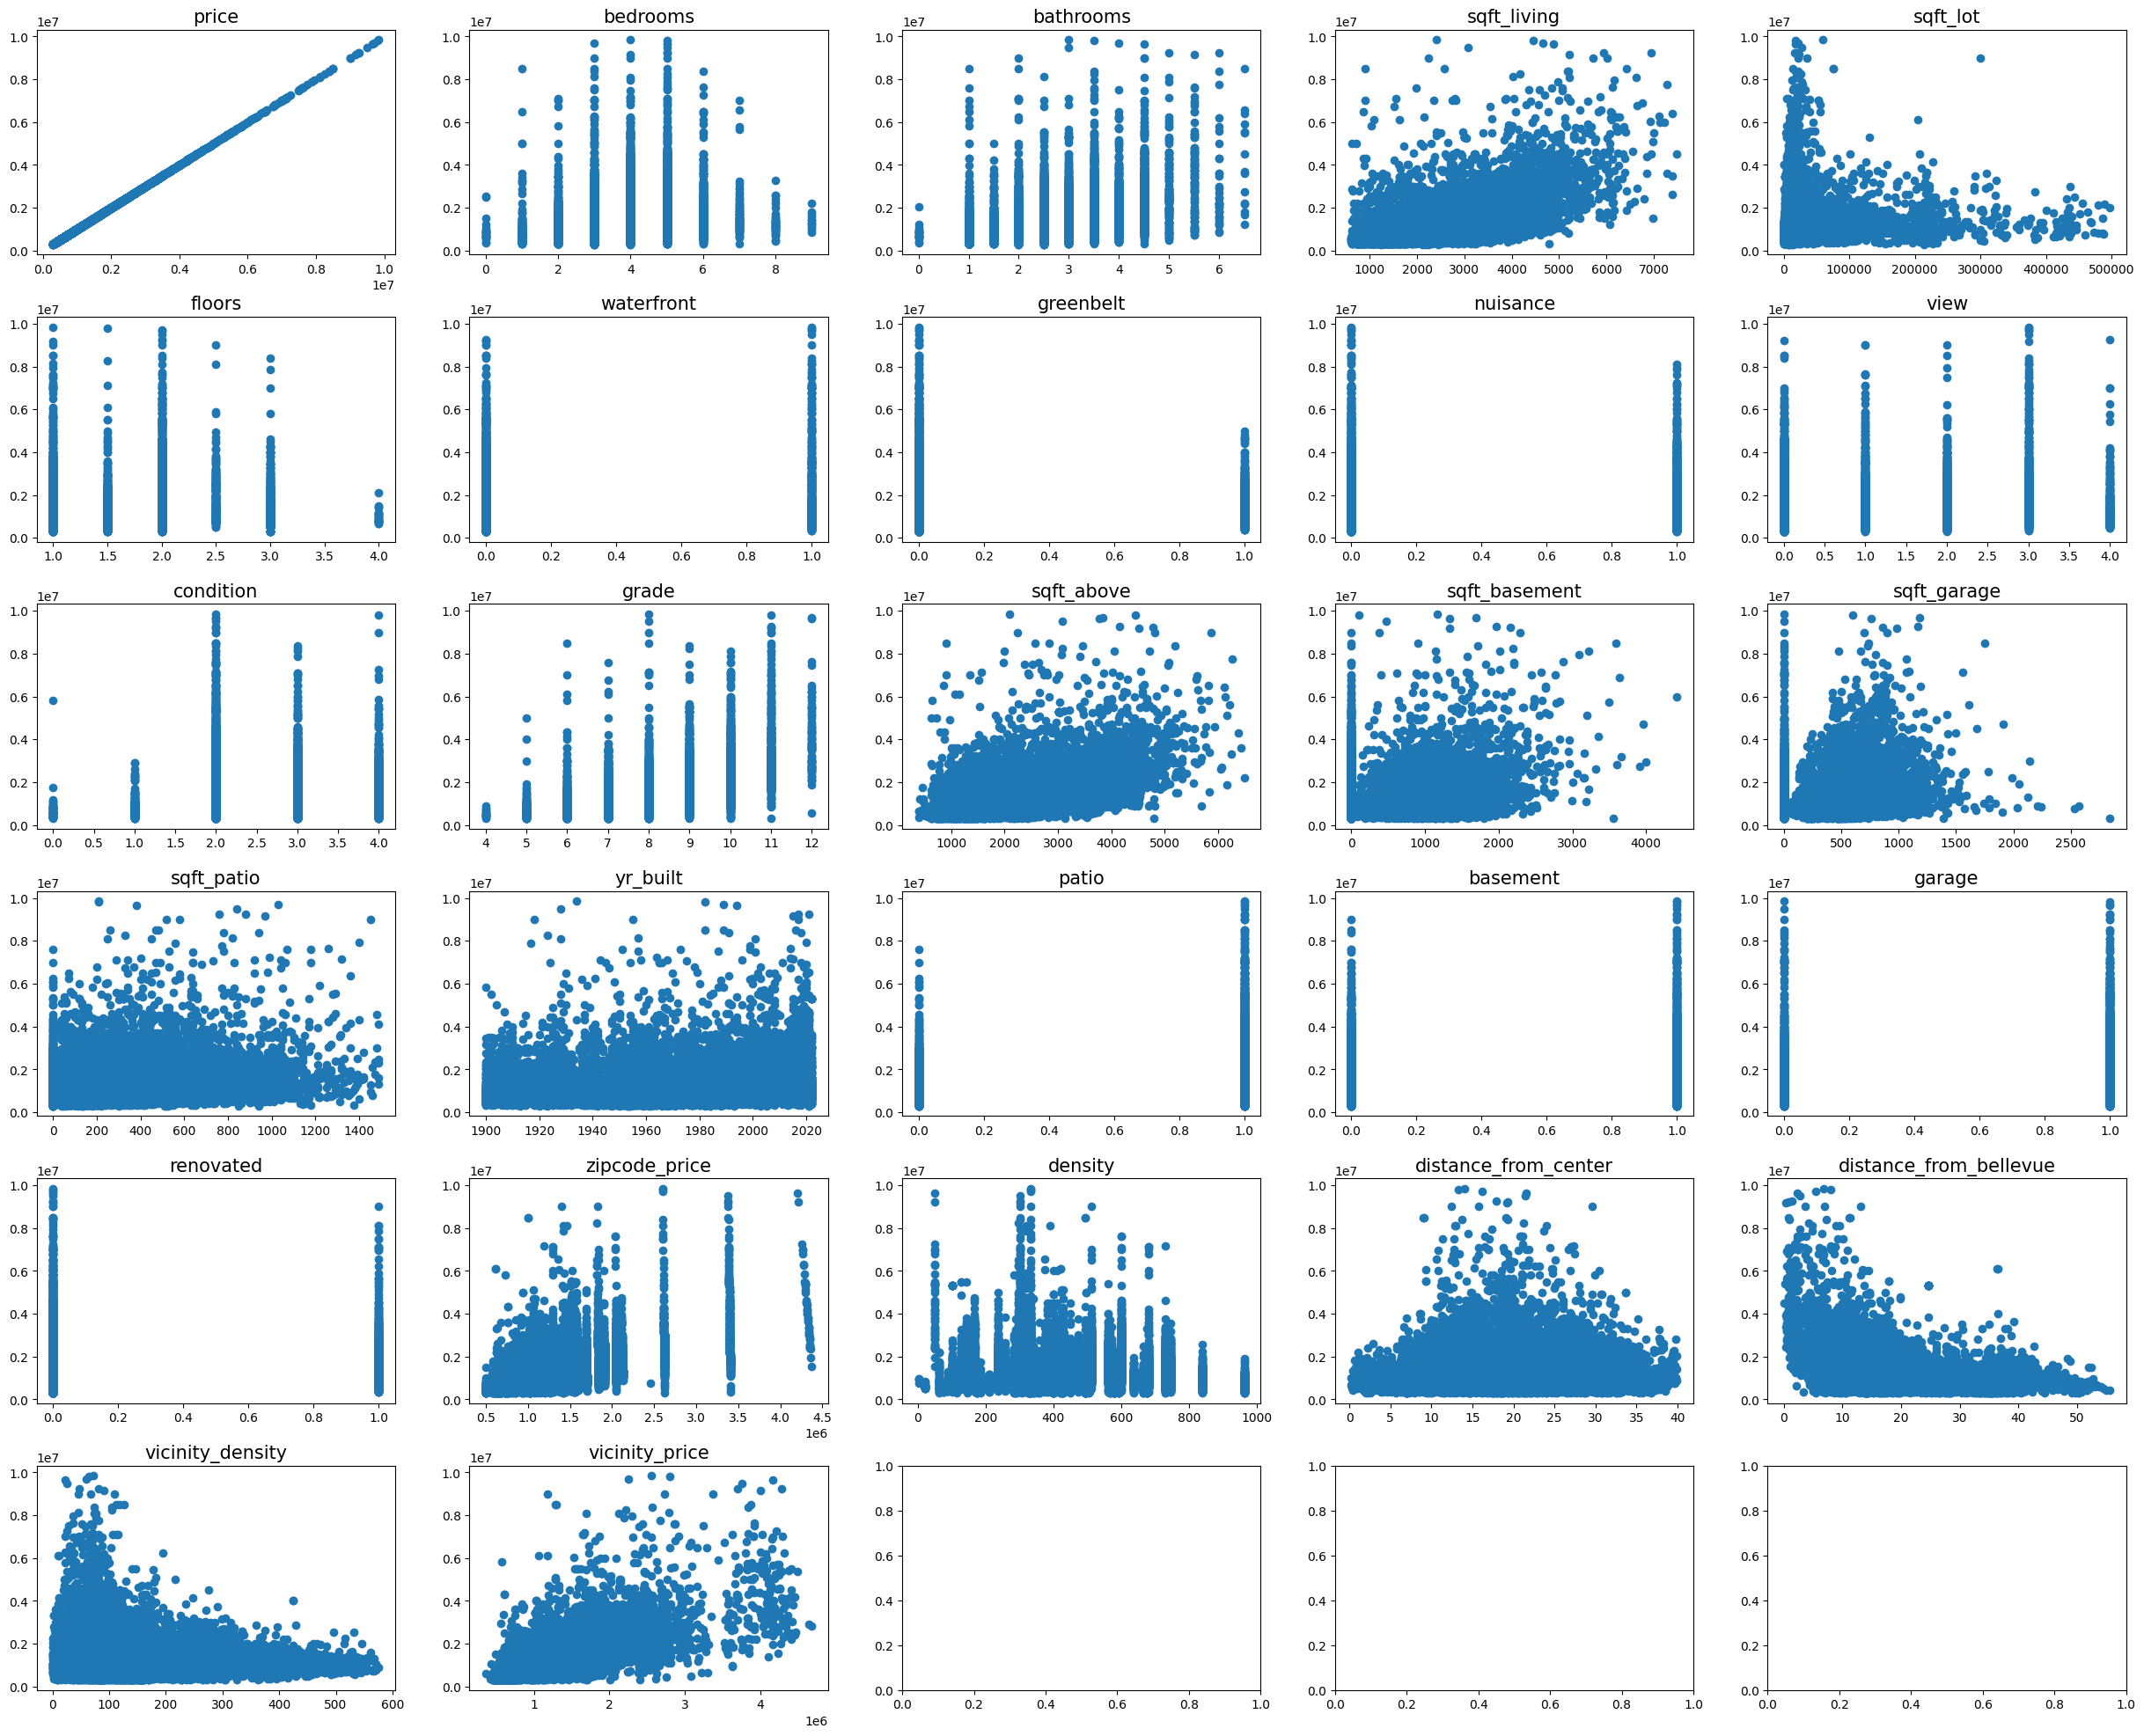

In [140]:
graph_df = df.drop(to_drop, axis=1).select_dtypes(include=['float64', 'int64'])
scatter(graph_df, graph_df.columns)

In [141]:
to_drop += ['bedrooms', 'sqft_lot', 'floors', 
         'view', 'density', 'distance_from_center', 
         'sqft_basement', 'sqft_garage', 'sqft_patio']

# Eliminating Collinearity and Weak Variables

Variables we are not using due to high collinearity:

- bathrooms
- grade
- sqft_above
- zipcode_price

Variables we are not using due to having an adjusted r-squared value of <0.1 in a linear regression model:

- waterfront
- heat_source
- patio
- vicinity_density
- garage
- basement
- yr_built
- renovated
- greenbelt
- sewer_system
- condition
- nuisance

In [191]:
strengths = variable_strength(df.drop(to_drop, axis=1), df.drop(to_drop, axis=1).columns)
strengths

,variables,rsquared_adj
0,price,1.000000
3,vicinity_price,0.523116
1,sqft_living,0.408250
2,distance_from_bellevue,0.156598


In [192]:
to_drop += ['waterfront', 'heat_source', 'patio', 
         'vicinity_density', 'garage', 'basement', 
         'yr_built', 'renovated', 'greenbelt', 
         'sewer_system', 'condition', 'nuisance']

In [193]:
df.drop(to_drop, axis=1).corr(numeric_only = True)

,price,sqft_living,distance_from_bellevue,vicinity_price
price,1.000000,0.638961,-0.395762,0.723279
sqft_living,0.638961,1.000000,-0.031503,0.385899
distance_from_bellevue,-0.395762,-0.031503,1.000000,-0.552117
vicinity_price,0.723279,0.385899,-0.552117,1.000000


In [194]:
to_drop += ['bathrooms', 'grade', 'sqft_above', 'zipcode_price']

# Model 1

In [195]:
model = sm.OLS.from_formula(f"price ~ vicinity_price", data=df)
results = model.fit()
print(results.summary())
print("\n\n")
mae = mean_absolute_error(df.price, results.predict(df))
rmse = mean_squared_error(df.price, results.predict(df))
print (f"MAE: {mae}\nRMSE: {rmse}")

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                 3.078e+04
Date:                Sat, 24 Jun 2023   Prob (F-statistic):               0.00
Time:                        22:40:59   Log-Likelihood:            -4.0933e+05
No. Observations:               28064   AIC:                         8.187e+05
Df Residuals:                   28062   BIC:                         8.187e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -2.674e+04   7189.055     -3.

# Model 2

In [196]:
model = sm.OLS.from_formula(f"price ~ vicinity_price + sqft_living + vicinity_price + distance_from_bellevue", data=df)
results = model.fit()
print(results.summary())
print("\n\n")
mae = mean_absolute_error(df.price, results.predict(df))
rmse = mean_squared_error(df.price, results.predict(df))
print (f"MAE: {mae}\nRMSE: {rmse}")

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                 2.019e+04
Date:                Sat, 24 Jun 2023   Prob (F-statistic):               0.00
Time:                        22:41:00   Log-Likelihood:            -4.0359e+05
No. Observations:               28064   AIC:                         8.072e+05
Df Residuals:                   28060   BIC:                         8.072e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -2.92

# Model 3

In [271]:
to_log = ['price', 'vicinity_price', 'sqft_living', 'distance_from_bellevue']
log_dict = {'logged vars': ["none"] + to_log, 
            'rsquared_adj': [0.698], 
            'mae': [215883.25147031213], 
            'rmse': [94614617291.437], 
            'rsquared_change': [0], 
            'mae_change': [0], 
            'rmse_change': [0]}

for log in to_log:
    
    df_log = df.copy()
    df_log[log] = np.log(df_log[log])
    
    model = sm.OLS.from_formula(f"price ~ vicinity_price + sqft_living + vicinity_price + distance_from_bellevue", data=df_log)
    results = model.fit()
    
    mae = mean_absolute_error(df_log.price, results.predict(df_log))
    rmse = mean_squared_error(df_log.price, results.predict(df_log))
    rsquared_adj = results.rsquared_adj
    
    log_dict['rsquared_adj'].append(rsquared_adj)
    log_dict['mae'].append(mae)
    log_dict['rmse'].append(rmse)
    
    log_dict['rsquared_change'].append(rsquared_adj - 0.698)
    log_dict['mae_change'].append(mae - 215883.25147031213)
    log_dict['rmse_change'].append(rmse - 94614617291.437)
    
pd.DataFrame(log_dict)

,logged vars,rsquared_adj,mae,rmse,rsquared_change,mae_change,rmse_change
0,none,0.698000,215883.251470,9.461462e+10,0.000000,0.000000,0.000000e+00
1,price,0.744942,0.190880,6.926360e-02,0.046942,-215883.060590,-9.461462e+10
2,vicinity_price,0.652261,263617.217517,1.992323e+11,-0.045739,47733.966047,1.046177e+11
3,sqft_living,0.643801,262442.994396,2.040795e+11,-0.054199,46559.742925,1.094649e+11
4,distance_from_bellevue,0.686316,244945.826348,1.797210e+11,-0.011684,29062.574877,8.510634e+10


In [272]:
to_log = ['price', 'vicinity_price']
logdf = df.copy()
for col in to_log:
    logdf[col] = np.log(logdf[col])

In [273]:
model = sm.OLS.from_formula(f"price ~ vicinity_price + sqft_living + distance_from_bellevue", data=logdf)
results = model.fit()
print(results.summary())
print("\n\n")
mae = mean_absolute_error(logdf.price, results.predict(logdf))
rmse = mean_squared_error(logdf.price, results.predict(logdf))
print (f"MAE: {mae}\nRMSE: {rmse}")

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                 3.099e+04
Date:                Sun, 25 Jun 2023   Prob (F-statistic):               0.00
Time:                        10:06:34   Log-Likelihood:                -1021.1
No. Observations:               28064   AIC:                             2050.
Df Residuals:                   28060   BIC:                             2083.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  4

# Model 4

In [274]:
single_family_homes = logdf.drop(logdf.query('bedrooms < 3 or \
                      sqft_living < 1500 or\
                      price > 3_000_000').index).copy()

In [276]:
mae = mean_absolute_error(single_family_homes.price, results.predict(single_family_homes))
rmse = mean_squared_error(single_family_homes.price, results.predict(single_family_homes))
print (f"MAE: {mae}\nRMSE: {rmse}")

MAE: 0.18200296775929356
RMSE: 0.06300370424027257


# Model 5

In [277]:
X = logdf[['vicinity_price', 'sqft_living', 'distance_from_bellevue']]
y = logdf['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.035, random_state=42)

In [278]:
## create, fit, score the model
model = LinearRegression()
model.fit(X_train, y_train)
lr_score = model.score(X_test, y_test)
print(lr_score)

0.7535270082874915
